In [1]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    inter       ::Int #split point of two material
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end

struct BoundCon
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


In [2]:
#module Initial
#export state1, problem1

    

function initial()
    

    nv = 3
    jx = 800
    tt = 1.5e-4
    cfl = 0.5
    lx =1.0
    inter=0
    kindProblem=1
    dx=lx/jx


    ρ2=8930
    u2=0.0
    p2=1.e5
    sxx2=0
    
    
    ρ1=8930
    u1=10.0
    p1=1.e5
    sxx1=0.0
    global    rB=BoundCon(ρ2,u2,p2,sxx2)
    global    lB=BoundCon(ρ1,u1,p1,sxx1)
    
    global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))

    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1 
        uo[i,1] = ρ1
        uo[i,2] = u2
        uo[i,3] = p1
        uo[i,4] = sxx1
        u[i,:]=UoTou(uo[i,:],con)
    end    

    global   problem=Global(nv,jx,inter,kindProblem, tt,cfl)
    return uo,u,x
end

#PyPlot.plot(x,uo[:,1:4])
#end

initial (generic function with 1 method)

$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [3]:

function fη(ρ::Float64,c::Const=con)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [4]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [5]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [6]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

In [7]:
function sound(uo::Array{Float64,1},con::Const=con)::Float64
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
    c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    return c
end


function Cfl(uo::Array{Float64,2},x::Array{Float64,1},problem::Global=problem,con::Const=con)
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
    dx1=0
    dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+nv+1
        dx  = x[i]-x[i-1]
        c = sound(uo[i,:],con)
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
    dt=sf*dx1
    return dt
end    


Cfl (generic function with 3 methods)

In [8]:
function Wilkins()
    
    nv = 3
    jx = 800
    tt = 5.e-6
    cfl = 0.5
    lx =5.e-2
    inter=0
    kindProblem=2
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=0.0
    global    rB=BoundCon(ρ2,u2,p2,sxx2)
    global    lB=BoundCon(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global   con = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))

    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1
        if x[i] < 5.e-3 
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con)
        end
    end

    global   problem=Global(nv,jx,inter,kindProblem, tt,cfl)
    return uo,u,x
end

Wilkins (generic function with 1 method)

In [9]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2/3
        c1 = 1/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
        
        c0 = 1/3
        c1 = 2/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
    end
    return uL,uR
end
        

WENO3 (generic function with 1 method)

In [10]:
function Upwind(u::Array{Float64,1})
     I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        uL[i] = u[i]
        uR[i] = u[i+1]
    end
    return uL,uR
end


Upwind (generic function with 1 method)

In [11]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if abs(s) <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

In [ ]:
$$s^* = \frac{\sigma_L -\sigma_R+\rho_L u_L(s_L-u_L)}$$

In [43]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        problem::Global=problem,con::Const=con)
    Y0 = con.Y0
    ρ0 = con.ρ0
    Γ0 = con.Γ0
    a0 = con.a0
    nv = problem.nv
    jx = problem.nv
    μ  = con.μ
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    ue = zeros(Float64,I)
    
    for i in 1:I
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:])
        eL = PToe(ρL, pL, con)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:])
        eR = PToe(ρR, pR, con)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μ/3*log(ρLstar/ρL) +sxxL
        if (abs(sxxL) < 2Y0/3 && abs(tmp) >= 2Y0/3)

       # if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0/3
                hsxxL = 2Y0/3
                hρL  = ρL*exp(-Y0/(2μ)+3sxxL/(4μ))
            elseif tmp < -2/3*Y0
                hsxxL = -2Y0/3
                hρL  = ρL*exp(Y0/(2μ)+3sxxL/(4μ))
            end
            t    = 1/ρL-1/hρL
            c0   = 1/(ρ0*Γ0)
            c1   = a0^2/Γ0
            hpL   = (2(c1*fη(hρL,con)+eL)-t*(σL+hsxxL))/(2c0-t)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)*t)
            else
               huuL = uuL +sqrt((σL-hσL)*t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,con)
        end
        
        tmp = -4.0μ/3*log(ρRstar/ρR) +sxxR
        if abs(sxxR) < 2Y0/3 && abs(tmp) >= 2Y0/3 
        #if abs(tmp) >= 2Y0/3
            if tmp > 2Y0/3
               hsxxR = 2Y0/3
               hρR  = ρR*exp(-Y0/(2μ)+3sxxR/(4μ))
            elseif tmp < -2/3*Y0
               hsxxR = -2Y0/3
               hρR  = ρR*exp(Y0/(2μ)+3sxxR/(4μ))
            end
            t    = 1/ρR-1/hρR
            c0   = 1/(ρ0*Γ0)
            c1   = a0^2/Γ0
           hpR   = (2(c1*fη(hρR,con)+eR)-t*(σR+hsxxR))/(2c0-t)
           hσR = -hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)*t)
            else
               huuR = uuR -sqrt((σR-hσR)*t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,con)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μ/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0/3
            sxxLstar = 2Y0/3
        elseif tmp <= -2Y0/3
            sxxLstar  = -2Y0/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μ/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0/3
            sxxRstar = 2Y0/3
        elseif tmp <= -2Y0/3
            sxxRstar  = -2Y0/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μ/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μ/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew (generic function with 3 methods)

In [13]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        problem::Global=problem,con::Const=con)
    Y0 = con.Y0
    ρ0 = con.ρ0
    Γ0 = con.Γ0
    μ  = con.μ
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1:I
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:])
        eL = PToe(ρL, pL, con)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:])
        eR = PToe(ρR, pR, con)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar)
        sxxR_star = Yυ(sxxR_bar)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxR_star-sxxR)/(ρR*(sR-uuR))
        
        
        s_star = (pR - pL + ρL*(uuL-sxL_star)*(sL-uuL) - ρR* (uuR-sxR_star)*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
        if s_star > u[i]
            f[i,1] = 0
            f[i,2] = pL_star-sxxL_star
            f[i,3] = (pL_star-sxxL_star)*s_star
            f[i,4] = -4μ/3*s_star 
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pR_star-sxxR_star
            f[i,3] = (pR_star-sxxR_star)*s_star
            f[i,4] = -4μ/3*s_star 
            uuh[i] = s_star
        end
    end
    return f, uuh
end
        

HLLCEP (generic function with 3 methods)

In [30]:
function Space(uo::Array{Float64,2},problem::Global=problem,con::Const=con)
    kind_split = 1
    nv = problem.nv
    h = zeros(Float64,2)
   
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
     if kind_split==1
        for i in 1:J
            uL[:,i],uR[:,i] = WENO3(uo[:,i])
            #uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
     #   h,uuh = HLLCEP(uo[:,2],uL,uR)
        h,uuh = HLLCEPNew(uo[:,2],uL,uR)
     end
    for i in 2:I-1
        f[i,:]= h[i,:]-h[i-1,:]
    end
    return f,uuh
end
        

Space (generic function with 3 methods)

In [15]:
function Bound!(uo::Array{Float64,2},u::Array{Float64,2},lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    ρ0 = con.ρ0
    uu = lB.u
    ρ  = lB.ρ
    
    if kind_prb == 1
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            uo[i,2] = uu
            u[i,:] = u[nv+1,:]
            u[i,2] = u[i,1]*uu
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            
            u[i+jx+nv+1,:]=u[jx+nv+1-i,:]
            u[i+jx+nv+1,2]=-u[jx+nv+1-i,2]
        end
    elseif kind_prb == 2
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,1] = ρ
            uo[i,2] = uo[nv+1,2]
            uo[i,3] = 0
            uo[i,4] = 0
            
            ue[1] = ρ
            ue[2] = u[nv+1,2]/ρ
            ue[3] = 0
            ue[4] = 0
            
            u[i,:] = UoTou(ue,con)
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end  
    end
    return uo,u
end

Bound! (generic function with 4 methods)

In [16]:
#function R_K(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem,con::Const=con,order::Int8=3)
#    if order==3
#       uo,x = R_K3(dt,uo,x)
#    end
#    return uo,x
#end
function R_K3(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},
        lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem,con::Const=con)
    μ = con.μ
    I,J=size(uo)
    dx = zeros(Float64,I)
    udx= zeros(Float64,(I,J))
    u= zeros(Float64,(I,J))
    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I    
        u[i,1:4]=UoTou(uo[i,1:4],con)
        udx[i,1:3]=u[i,1:3]*dx[i]
        udx[i,4] =u[i,4]
    end 
    
    uo,u = Bound!(uo,u)
#****************1**********************    
    f,uuh=Space(uo)   
    #x1 = zeros(Float64,I) 
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
        udx1[i,4] = udx[i,4] -dt*f[i,4]/dx[i]
    end
    
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    dx[1] =dx[2]
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:3] = udx[i,1:3] -dt*f[i,1:3]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=  udx1[i,4]
        u[i,4]= Yυ(u[i,4])
        uo[i,:] = UToUo(u[i,:],con)
    end
    
    uo,u = Bound!(uo,u)
# #***************2***********************    
    
    f,uuh = Space(uo)
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
   
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
        udx2[i,4] = 3/4*udx[i,4]+1/4*udx1[i,4] -1/4*dt*f[i,4]/dx[i]
    end
   
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        udx2[i,1:3] = 3/4*udx[i,1:3]+1/4*udx1[i,1:3] -1/4*dt*f[i,1:3]
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]   = udx2[i,4]
        u[i,4]= Yυ(u[i,4])
        uo[i,:] = UToUo(u[i,:],con)
    end    
    uo,u = Bound!(uo,u)
  #***************3**********************   
    f,uuh = Space(uo)
  
   for i in 1:I
       x[i] = 1/3*x[i] +2/3*x2[i]+2/3*dt*uuh[i]
        udx[i,4] = 1/3*udx[i,4]+2/3*udx2[i,4] -2/3*dt*f[i,4]/dx[i]
    end
    for i in 2:I
        dx[i] = x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    
    for i in 1:I
        udx[i,1:3] = 1/3*udx[i,1:3]+2/3*udx2[i,1:3] -2/3*dt*f[i,1:3]
        u[i,1:3] = udx[i,1:3]/dx[i]
        u[i,4]=udx[i,4]
        u[i,4]= Yυ(u[i,4])
        uo[i,:] = UToUo(u[i,:],con)
     end
    uo,u = Bound!(uo,u)
    
    return uo,x
end

    
    
    

R_K3 (generic function with 5 methods)

In [31]:
function TimeSolve(uo::Array{Float64,2},x::Array{Float64,1})
#    uo,u,x=initial()
    tt= problem.tt
    
    t=0 
    it =1
    
    plt = Plots.plot() 
    while t<tt
  #  for i in 1:5
        dt=Cfl(uo,x)
        if t+dt>tt
           dt = tt-t
        end
        t += dt
        uo,x=R_K3(dt,uo,x)
        #if t/(tt/10) > it
        #    it += 1
            println(dt,"  ", t)
         #  plot(x,uo[:,1])
        #end
    end
    
    return uo,x
end

TimeSolve (generic function with 2 methods)

In [44]:
using Plots
uo,u,x = Wilkins()
uo,x = TimeSolve(uo,x)

4.845035279033152e-9  4.845035279033152e-9
4.718025601602392e-9  9.563060880635545e-9
4.6322194600144046e-9  1.4195280340649949e-8
4.575438196371225e-9  1.8770718537021174e-8
4.53923227258061e-9  2.3309950809601786e-8
4.518759133893819e-9  2.7828709943495604e-8
4.510536710446182e-9  3.233924665394178e-8
4.511038153200791e-9  3.685028480714257e-8
4.516773332797643e-9  4.1367058139940213e-8
4.525002621561871e-9  4.5892060761502086e-8
4.5206155988303926e-9  5.041267636033248e-8
4.5133897865387446e-9  5.4926066146871224e-8
4.513706176533552e-9  5.943977232340478e-8
4.51723838631939e-9  6.395701070972417e-8
4.520515480916977e-9  6.847752619064115e-8
4.5228888614203015e-9  7.300041505206145e-8
4.522332579409839e-9  7.752274763147129e-8
4.521904319921397e-9  8.204465195139268e-8
4.5215317402749256e-9  8.656618369166761e-8
4.519750826281785e-9  9.10859345179494e-8
4.51794819025335e-9  9.560388270820275e-8
4.5176546902178145e-9  1.0012153739842056e-7
4.518129763354411e-9  1.0463966716177497e-7


4.519404799534935e-9  9.045747170604438e-7
4.5194213234123415e-9  9.090941383838562e-7
4.519401369259813e-9  9.13613539753116e-7
4.519389721240559e-9  9.181329294743565e-7
4.519418666503825e-9  9.226523481408603e-7
4.519409489084436e-9  9.271717576299448e-7
4.519426019723602e-9  9.316911836496683e-7
4.5193888630933605e-9  9.362105725127617e-7
4.519412187476204e-9  9.407299847002379e-7
4.5194089380187805e-9  9.452493936382567e-7
4.5194149990754716e-9  9.497688086373322e-7
4.519425878649162e-9  9.542882345159813e-7
4.519386662536917e-9  9.588076211785182e-7
4.519428213989227e-9  9.633270493925074e-7
4.519403579099459e-9  9.678464529716067e-7
4.5194181661914425e-9  9.723658711377983e-7
4.519414929548845e-9  9.76885286067347e-7
4.5193947531796855e-9  9.814046808205268e-7
4.519419828286334e-9  9.859241006488132e-7
4.519404620327735e-9  9.90443505269141e-7
4.51942213176442e-9  9.949629274009054e-7
4.5193995549113e-9  9.994823269558167e-7
4.519418543144549e-9  1.0040017454989612e-6
4.51941096

4.5194197443247085e-9  1.7587446020707685e-6
4.519422058013345e-9  1.763264024128782e-6
4.5194384940399195e-9  1.7677834626228218e-6
4.519412609942835e-9  1.7723028752327646e-6
4.519428115423429e-9  1.776822303348188e-6
4.519412433733655e-9  1.7813417157819215e-6
4.5194197288518145e-9  1.7858611355107734e-6
4.519438382038409e-9  1.7903805738928119e-6
4.519414768487535e-9  1.7948999886612995e-6
4.519423198084983e-9  1.7994194118593845e-6
4.5194138556724475e-9  1.8039388257150569e-6
4.5194240148277346e-9  1.8084582497298847e-6
4.519426539106143e-9  1.8129776762689907e-6
4.5194255351058725e-9  1.8174971018040966e-6
4.519420999438781e-9  1.8220165228035354e-6
4.519421904729894e-9  1.8265359447082652e-6
4.519437199768774e-9  1.8310553819080339e-6
4.519414805458419e-9  1.8355747967134924e-6
4.519428561110823e-9  1.8400942252746033e-6
4.519412586231761e-9  1.844613637860835e-6
4.519419176775431e-9  1.8491330570376106e-6
4.519442500514938e-9  1.8536524995381254e-6
4.519414676466041e-9  1.85817

4.519434576476083e-9  2.6174354263468203e-6
4.519434857785023e-9  2.621954861204605e-6
4.5194222826633345e-9  2.6264742834872686e-6
4.519421446222027e-9  2.6309937049334908e-6
4.519437300012312e-9  2.6355131422335033e-6
4.51942352048195e-9  2.640032565753985e-6
4.5194370888168574e-9  2.644552002842802e-6
4.519413013441515e-9  2.6490714158562435e-6
4.5194190134853e-9  2.6535908348697287e-6
4.519441485868818e-9  2.6581102763555976e-6
4.519424416614525e-9  2.6626297007722123e-6
4.519426872192128e-9  2.6671491276444043e-6
4.519413363649614e-9  2.671668541008054e-6
4.519422708529126e-9  2.676187963716583e-6
4.519438024512759e-9  2.680707401741096e-6
4.519434789443674e-9  2.6852268365305396e-6
4.519423685228063e-9  2.6897462602157676e-6
4.519421385783607e-9  2.694265681601551e-6
4.519436114530702e-9  2.6987851177160817e-6
4.519425104531918e-9  2.7033045428206138e-6
4.5194382908084465e-9  2.7078239811114223e-6
4.519413531966623e-9  2.7123433946433888e-6
4.519418791927604e-9  2.716862813435316

4.519426939112056e-9  3.507762668851387e-6
4.519439848858948e-9  3.5122821087002457e-6
4.5194133352120844e-9  3.516801522035458e-6
4.519418693979046e-9  3.521320940729437e-6
4.519440628225636e-9  3.5258403813576627e-6
4.519426738221553e-9  3.530359808095884e-6
4.519428338597266e-9  3.534879236434481e-6
4.519412968737947e-9  3.539398649403219e-6
4.5194218170758015e-9  3.5439180712202947e-6
4.519438551924358e-9  3.548437509772219e-6
4.51943688802963e-9  3.5529569466602486e-6
4.519424782109132e-9  3.5574763714423576e-6
4.519420945045493e-9  3.561995792387403e-6
4.519435068858373e-9  3.5665152274562614e-6
4.5194286395777335e-9  3.5710346560958394e-6
4.5194406280174664e-9  3.575554096723857e-6
4.519414353986374e-9  3.5800735110778436e-6
4.519418796606048e-9  3.5845929298744497e-6
4.5194406960909385e-9  3.5891123705705405e-6
4.5194265697463994e-9  3.5936317971402867e-6
4.519429992429906e-9  3.5981512271327164e-6
4.5194128000110535e-9  3.6026706399327274e-6
4.51942096334482e-9  3.607190060896

4.519440652807716e-9  4.443284182868519e-6
4.519415080225335e-9  4.447803597948744e-6
4.519418723720192e-9  4.452323016672464e-6
4.51943990454254e-9  4.4568424565770066e-6
4.519426734590681e-9  4.461361883311597e-6
4.5194310184167204e-9  4.465881314330014e-6
4.519412589869089e-9  4.470400726919883e-6
4.519420400193066e-9  4.474920147320076e-6
4.519438717244148e-9  4.4794395860373195e-6
4.519435107200651e-9  4.48395902114452e-6
4.519425953713819e-9  4.4884784470982335e-6
4.519418852750895e-9  4.4929978659509844e-6
4.51943136701352e-9  4.497517297317998e-6
4.519432461088061e-9  4.5020367297790865e-6
4.51944068367497e-9  4.5065561704627614e-6
4.519417593096754e-9  4.511075588055858e-6
4.519419831795376e-9  4.515595007887654e-6
4.5194395905966324e-9  4.520114447478251e-6
4.519427032463391e-9  4.524633874510714e-6
4.519433151675356e-9  4.529153307662389e-6
4.519413051547381e-9  4.533672720713937e-6
4.519420361898393e-9  4.538192141075835e-6
4.5194395665825825e-9  4.5427115806424175e-6
4.519

([2785.0 6.92687 0.0 0.0; 2785.0 6.92687 0.0 0.0; … ; 2785.0 -9.12814e-11 -0.0175537 -0.0183584; 2785.0 -9.26261e-11 0.00877836 0.00797893], [NaN, 0.000609438, 0.000670748, 0.000733156, 0.000795545, 0.000857939, 0.000920336, 0.00098273, 0.00104513, 0.00110752  …  0.0496562, 0.0497187, 0.0497812, 0.0498437, 0.0499062, 0.0499687, 0.0500312, 0.0500937, NaN, NaN])

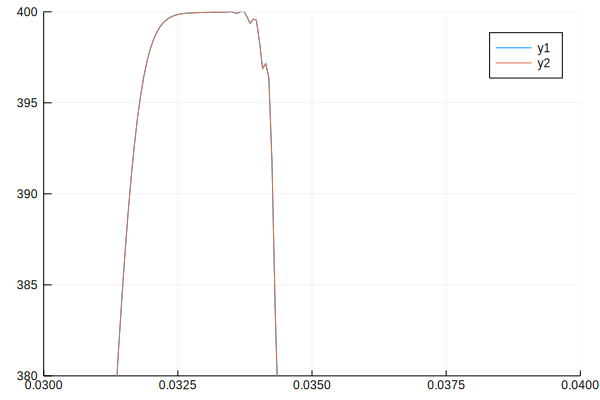

In [46]:
#plot(x,uo[:,2])
#plot!(x,uo[:,3])
#plot!(x,uo[:,4])
plot!(x,uo[:,2],xlims = (0.03,0.04),ylims=(380,400))

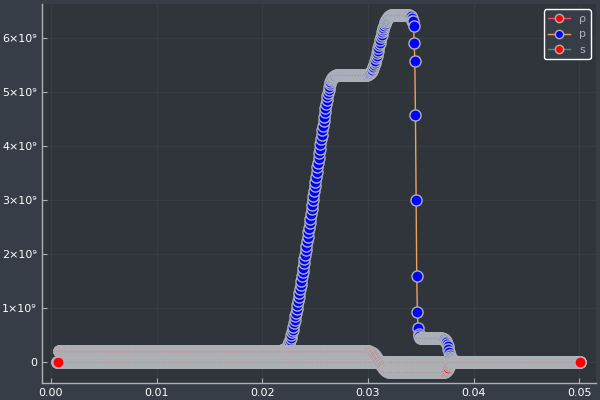

In [242]:
#unicodeplots()
pyplot()
plot(x,uo[:,2:4],#xlims = (0.03,0.035),
    #ylims = (6.4e9,6.5e9),
   # bg = "white",
   # fg = "Black",
    marker = (8,[:red :blue]),label = [ "ρ" "p" "s"])